In [235]:
keras.backend.clear_session()

In [285]:
from IPython.display import Image
from IPython.core.display import HTML 
from collections import Counter

import cv2
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt 
import os
import os.path
import shutil
import seaborn as sns
import joblib

# Keras Libraries
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from keras.utils import plot_model
from sklearn.metrics import multilabel_confusion_matrix

#### This function serves to feed in the from the train, validation and test image datasets, label them appropiately as a 0 or a 1 based on their location (either in the Pneumonia or Normal files). Then, it iterates through the images, converts them to grayscale, resizes the image to a smaller 128 x 128 dimension and converts it into an array of numbers. This list of pixels, along with the label (0 or 1), is then appended into the an array. 

In [331]:
labels = ['PNEUMONIA', 'NORMAL', 'COVID']

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        print(path)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), 
                                     cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (128, 128))
                data.append([resized_arr, class_num])
            
            except Exception as e:
                print(e)
    return np.array(data)

In [332]:
train = get_training_data(r"C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\train")
val = get_training_data(r"C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\val")
test = get_training_data(r"C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\test")

C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\train\PNEUMONIA
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\train\NORMAL
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\train\COVID
OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\val\PNEUMONIA
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\val\NORMAL
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\val\COVID
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\test\PNEUMONIA
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\test\NORMAL
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\test\COVID


#### Here's the distribution of our images per set.
#### I have now included additional CT scans from COVID-19 patients in the dataset.

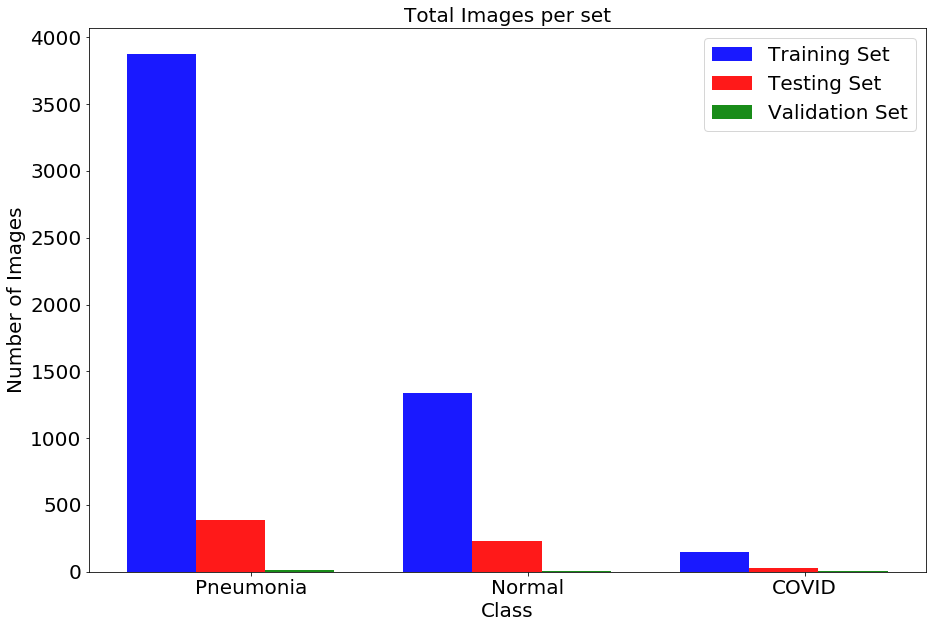

In [252]:
train_cases = pd.DataFrame(train)
test_cases = pd.DataFrame(test)
val_cases = pd.DataFrame(val)

train_cases = train_cases[1].value_counts()
test_cases = test_cases[1].value_counts()
val_cases = val_cases[1].value_counts()

labels = ['PNEUMONIA', 'NORMAL', 'COVID']

index = np.arange(len(labels))
bar_width = 0.25
opacity = 0.9

fig, ax = plt.subplots(figsize = (15, 10))

train_bar = ax.bar(index - bar_width, train_cases, bar_width,
                alpha=opacity, color='b',
                label='Training Set')

test_bar = ax.bar(index, test_cases, bar_width,
                alpha=opacity, color='r', tick_label = ('Pneumonia', 'Normal', 'COVID'),
                label='Testing Set')
val_bar = ax.bar(index + bar_width, val_cases, bar_width,
                  alpha=opacity, color='g', tick_label = ('Pneumonia', 'Normal', 'COVID'),
                label='Validation Set')


plt.xlabel('Class', fontsize = 20)
plt.ylabel('Number of Images', fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Total Images per set', fontsize = 20)
plt.xticks(index + 0.3 *  bar_width, fontsize = 20)
plt.legend(fontsize = 20)

plt.show()

#### Here's a further breakdown of the how the images are distributed in the set.

In [253]:
def percentage(image_set):
    for l, i in zip(labels, list(image_set)):
        num = (int(i) / sum(list(image_set)))
        print(l,' images make up ',round(num * 100),'% of the set')

In [254]:
percentage(train_cases)

PNEUMONIA  images make up  72 % of the set
NORMAL  images make up  25 % of the set
COVID  images make up  3 % of the set


In [255]:
percentage(test_cases)

PNEUMONIA  images make up  59 % of the set
NORMAL  images make up  36 % of the set
COVID  images make up  5 % of the set


In [256]:
percentage(val_cases)

PNEUMONIA  images make up  48 % of the set
NORMAL  images make up  26 % of the set
COVID  images make up  26 % of the set


#### As mentioned in the previous notebook, our dataset is quite unbalanced, which might affect the fit of the CNN. In order to avoid this, I will use the ImageDataGenerator, which I will describe later.

## Preparing the image data for implementation into our CNN.

#### Here, I extract the feature (the numpy array per image), and the label (the class of the image), and append the data into x and y sets.  

In [333]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [336]:
pd.Series(y_test).value_counts()

0    390
1    234
2     32
dtype: int64

In [258]:
x_train[0]

array([[19, 27, 30, ..., 16,  9,  2],
       [24, 26, 34, ..., 17, 11,  4],
       [22, 30, 39, ..., 19, 11,  4],
       ...,
       [10,  8,  7, ..., 15, 15, 15],
       [10,  8,  7, ..., 15, 15, 15],
       [10, 10,  7, ..., 15, 15, 15]], dtype=uint8)

### As we now have a multi-class classification, we need to convert our labels to be categorical.

In [259]:
y_train = to_categorical(y_train)

In [260]:
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

### Reducing the Colour Data Down to Grayscale (0 - 1) instead of (0 - 255)

#### This significantly reduces the amount of information that the neural network needs to process, thereby reducing the amount of data that's needed to be allocated to memory and reducing the computation time.

In [262]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [263]:
x_train.shape

(5365, 128, 128)

In [267]:
img_size = 128
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [268]:
y_val

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [269]:
print(x_train.shape)

(5365, 128, 128, 1)


In [178]:
x_train[0]

array([[[0.0745098 ],
        [0.10588235],
        [0.11764706],
        ...,
        [0.0627451 ],
        [0.03529412],
        [0.00784314]],

       [[0.09411765],
        [0.10196078],
        [0.13333333],
        ...,
        [0.06666667],
        [0.04313725],
        [0.01568627]],

       [[0.08627451],
        [0.11764706],
        [0.15294118],
        ...,
        [0.0745098 ],
        [0.04313725],
        [0.01568627]],

       ...,

       [[0.03921569],
        [0.03137255],
        [0.02745098],
        ...,
        [0.05882353],
        [0.05882353],
        [0.05882353]],

       [[0.03921569],
        [0.03137255],
        [0.02745098],
        ...,
        [0.05882353],
        [0.05882353],
        [0.05882353]],

       [[0.03921569],
        [0.03921569],
        [0.02745098],
        ...,
        [0.05882353],
        [0.05882353],
        [0.05882353]]])

### ImageDataGenerator
#### This parameter can be used to generate more data from our dataset by feeding in images and manipulating them by flipping their horizontal axis or rotating them. This serves as a way to artificially increase the size of our dataset. This is applied to both the Training Data and Validation Data.

In [179]:
datagen = ImageDataGenerator(horizontal_flip = True,
                             rotation_range = 5,
                            zoom_range = 0.1,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2)

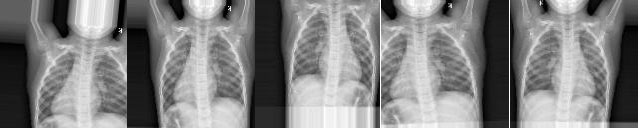

# CNN Model

### Below I utilised the same model as I used in my previous notebook to assess wherever this can differentiate between COVID-19 induced pneumonia and the previous pneumonia images.

In [273]:
model = Sequential()

#Convolution 
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 1)))

#Pooling
model.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
model.add(Conv2D(32, (3, 3), activation="relu"))

# 2nd Pooling layer
model.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the layer - this flattens the 3D feature maps into 1D 
# feature vectors.
model.add(Flatten())

# Density
model.add(Dense(activation = 'relu', units = 2048, kernel_initializer = 'uniform'))
model.add(Dense(activation = 'relu', units = 1024, kernel_initializer = 'uniform'))
model.add(Dense(activation = 'relu', units = 512, kernel_initializer = 'uniform'))
model.add(Dense(activation = 'relu', units = 265, kernel_initializer = 'uniform'))
model.add(Dense(activation = 'softmax', units = 3, kernel_initializer = 'uniform'))

# Compile 
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [274]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 2048)              58984448  
_________________________________________________________________
dense_27 (Dense)             (None, 1024)             

In [275]:
model_covid = model.fit(datagen.flow(x_train, y_train, batch_size = 64), epochs = 20,
                                  validation_data = datagen.flow(x_val, y_val))

Epoch 1/20
84/84 [==============================] - 79s 942ms/step - loss: 0.6609 - accuracy: 0.7236 - val_loss: 1.6378 - val_accuracy: 0.2903
Epoch 2/20
84/84 [==============================] - 79s 939ms/step - loss: 0.4082 - accuracy: 0.8382 - val_loss: 1.8378 - val_accuracy: 0.3548
Epoch 3/20
84/84 [==============================] - 80s 951ms/step - loss: 0.3019 - accuracy: 0.8816 - val_loss: 0.9258 - val_accuracy: 0.6452
Epoch 4/20
84/84 [==============================] - 82s 982ms/step - loss: 0.2746 - accuracy: 0.8986 - val_loss: 1.1091 - val_accuracy: 0.6774
Epoch 5/20
84/84 [==============================] - 85s 1s/step - loss: 0.2445 - accuracy: 0.9048 - val_loss: 1.2701 - val_accuracy: 0.6129
Epoch 6/20
84/84 [==============================] - 83s 984ms/step - loss: 0.2304 - accuracy: 0.9118 - val_loss: 1.0148 - val_accuracy: 0.6774
Epoch 7/20
84/84 [==============================] - 84s 995ms/step - loss: 0.2188 - accuracy: 0.9158 - val_loss: 0.6180 - val_accuracy: 0.7742
Ep

### As you can see, the accuracy of the model is quite good at 87%, whilst the losses could be improved with further tweaking of the CNN.

In [276]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

656/656 [==============================] - 2s 3ms/step
Loss of the model is -  41.88435183974301 %
656/656 [==============================] - 2s 3ms/step
Accuracy of the model is -  84.90853905677795 %


In [277]:
print("training_accuracy", model_covid.history['accuracy'][-1])
print("validation_accuracy", model_covid.history['val_accuracy'][-1])

training_accuracy 0.9383038
validation_accuracy 0.7096773982048035


In [299]:
predictions = model.predict_classes(x_test, batch_size = 128)
predictions = predictions.reshape(1,-1)[0]
predictions = to_categorical(predictions)
predictions

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

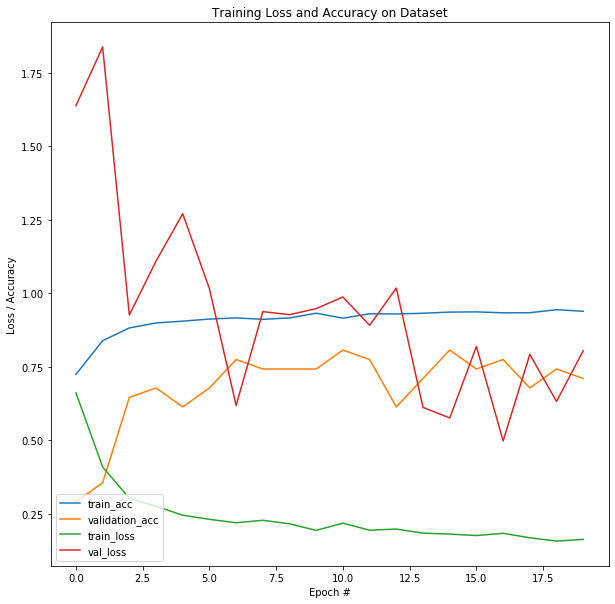

In [281]:
plt.figure(figsize = (10,10))
plt.plot(model_covid.history['accuracy'], label = "train_acc")
plt.plot(model_covid.history['val_accuracy'], label = "validation_acc")
plt.plot(model_covid.history['loss'], label = "train_loss")
plt.plot(model_covid.history['val_loss'], label = "val_loss")
plt.title('Training Loss and Accuracy on Dataset')
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='lower left')
plt.show()

### Below is the confusion matrix for this CNN. As you can see, the model has issues distinguishing between COVID-19 Pneumonia and regular Pneumonia. This makes sense because the number of COVID-19 Pneumonia images are far smallerthan the regular Pneumonia dataset. In addition, as the two types of pneumonia are similar (viral induced), it would be difficult for the model to distinguish.

### On a positive note, this highlights the ability for the dataset to track pneumonia in new images, and classify them. With a larger set of images, this could be further improved.

In [302]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)','COVID (Class 2)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.83      0.98      0.90       390
   Normal (Class 1)       0.97      0.61      0.75       234
    COVID (Class 2)       0.63      0.97      0.77        32

          micro avg       0.85      0.85      0.85       656
          macro avg       0.81      0.85      0.80       656
       weighted avg       0.87      0.85      0.84       656
        samples avg       0.85      0.85      0.85       656



In [322]:
cm = multilabel_confusion_matrix(y_test, predictions)
cm

array([[[190,  76],
        [  6, 384]],

       [[417,   5],
        [ 92, 142]],

       [[606,  18],
        [  1,  31]]], dtype=int64)

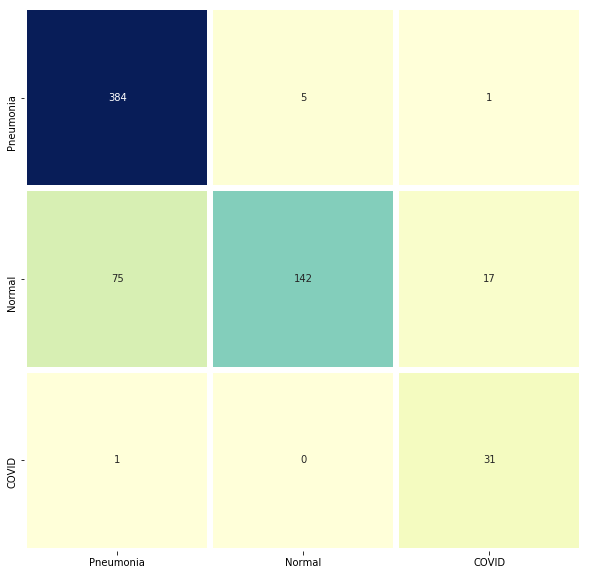

In [329]:
cm = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1))
cm_df = pd.DataFrame(cm)
plt.figure(figsize = (10,10))
sns.heatmap(cm_df, linewidth = 5 , annot = True, fmt='d',
           xticklabels = ['Pneumonia', 'Normal', 'COVID'],
           yticklabels = ['Pneumonia', 'Normal', 'COVID'],
           cbar = False, cmap = "YlGnBu")

In [337]:
model.save('model_PNEUCOVIDCOMPARE_FINAL 25.05.2020.model')
model.save_weights('model_PNEUCOVIDCOMPARE_FINAL 25.05.2020.h5')

### I decided to also explore further balancing dataset by 1) increasing the ratio of test to train data (80:20) 2) also significantly reduce the size of the dataset to match the number of COVID-19 images.

In [338]:
train.shape

(5365, 2)

In [339]:
test.shape

(656, 2)

In [340]:
val.shape

(31, 2)

### As I am unable to increase the size of the test imageset, I have chosen to reduce the training dataset. 

In [341]:
labels = ['PNEUMONIA', 'NORMAL', 'COVID']

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        print(path)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), 
                                     cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (128, 128))
                data.append([resized_arr, class_num])
            
            except Exception as e:
                print(e)
    return np.array(data)

In [342]:
train = get_training_data(r"C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\train")
val = get_training_data(r"C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\val")
test = get_training_data(r"C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\test")

C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\train\PNEUMONIA
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\train\NORMAL
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\train\COVID
OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\val\PNEUMONIA
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\val\NORMAL
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\val\COVID
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\test\PNEUMONIA
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\test\NORMAL
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\test\COVID


In [343]:
632 / 5244 * 100

12.051868802440884

In [344]:
632 / 3160 * 100

20.0

In [345]:
5244 - 3160

2084

In [346]:
train = train[2084:]

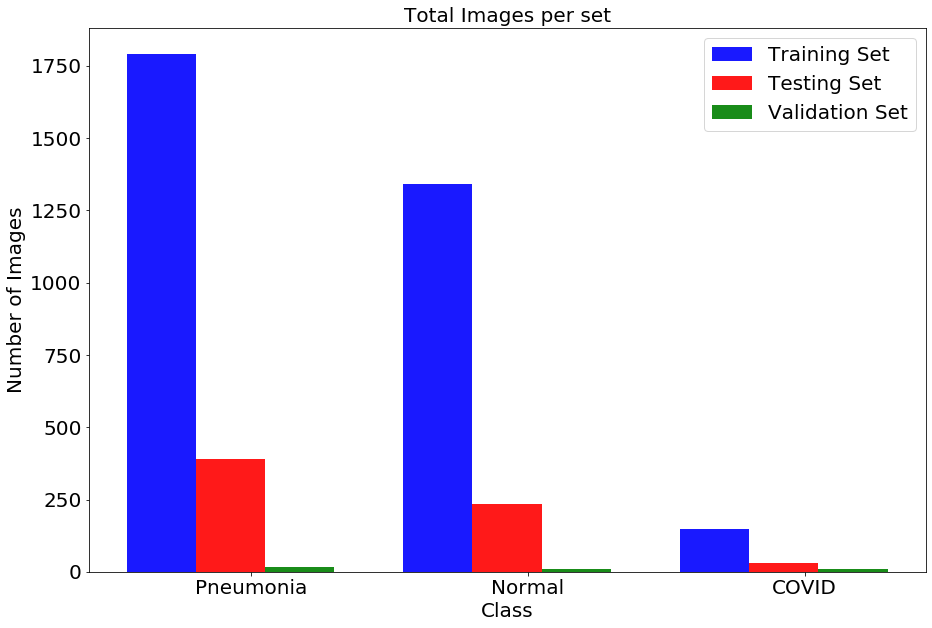

In [347]:
train_cases = pd.DataFrame(train)
test_cases = pd.DataFrame(test)
val_cases = pd.DataFrame(val)

train_cases = train_cases[1].value_counts()
test_cases = test_cases[1].value_counts()
val_cases = val_cases[1].value_counts()

labels = ['PNEUMONIA', 'NORMAL', 'COVID']

index = np.arange(len(labels))
bar_width = 0.25
opacity = 0.9

fig, ax = plt.subplots(figsize = (15, 10))

train_bar = ax.bar(index - bar_width, train_cases, bar_width,
                alpha=opacity, color='b',
                label='Training Set')

test_bar = ax.bar(index, test_cases, bar_width,
                alpha=opacity, color='r', tick_label = ('Pneumonia', 'Normal', 'COVID'),
                label='Testing Set')
val_bar = ax.bar(index + bar_width, val_cases, bar_width,
                  alpha=opacity, color='g', tick_label = ('Pneumonia', 'Normal', 'COVID'),
                label='Validation Set')


plt.xlabel('Class', fontsize = 20)
plt.ylabel('Number of Images', fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Total Images per set', fontsize = 20)
plt.xticks(index + 0.3 *  bar_width, fontsize = 20)
plt.legend(fontsize = 20)

plt.show()

In [349]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [350]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [351]:
y_train = to_categorical(y_train)

In [352]:
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [353]:
img_size = 128
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [354]:
model_covid_split = model.fit(datagen.flow(x_train, y_train, batch_size = 128), epochs = 20,
                                  validation_data = datagen.flow(x_val, y_val))

Epoch 1/20
26/26 [==============================] - 35s 1s/step - loss: 0.1837 - accuracy: 0.9375 - val_loss: 0.4875 - val_accuracy: 0.8710
Epoch 2/20
26/26 [==============================] - 36s 1s/step - loss: 0.1632 - accuracy: 0.9427 - val_loss: 0.4290 - val_accuracy: 0.8387
Epoch 3/20
26/26 [==============================] - 35s 1s/step - loss: 0.1500 - accuracy: 0.9467 - val_loss: 0.4593 - val_accuracy: 0.8387
Epoch 4/20
26/26 [==============================] - 35s 1s/step - loss: 0.1477 - accuracy: 0.9448 - val_loss: 0.6189 - val_accuracy: 0.8065
Epoch 5/20
26/26 [==============================] - 35s 1s/step - loss: 0.1499 - accuracy: 0.9473 - val_loss: 0.4445 - val_accuracy: 0.8387
Epoch 6/20
26/26 [==============================] - 35s 1s/step - loss: 0.1501 - accuracy: 0.9470 - val_loss: 0.3956 - val_accuracy: 0.8710
Epoch 7/20
26/26 [==============================] - 35s 1s/step - loss: 0.1462 - accuracy: 0.9467 - val_loss: 0.4963 - val_accuracy: 0.8387
Epoch 8/20
26/26 [==

In [357]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

656/656 [==============================] - 2s 3ms/step
Loss of the model is -  32.247731961855074 %
656/656 [==============================] - 2s 3ms/step
Accuracy of the model is -  87.5 %


In [356]:
print("training_accuracy", model_covid_split.history['accuracy'][-1])
print("validation_accuracy", model_covid_split.history['val_accuracy'][-1])

training_accuracy 0.9533679
validation_accuracy 0.8387096524238586


In [358]:
predictions = model.predict_classes(x_test, batch_size = 128)
predictions = predictions.reshape(1,-1)[0]
predictions = to_categorical(predictions)
predictions

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

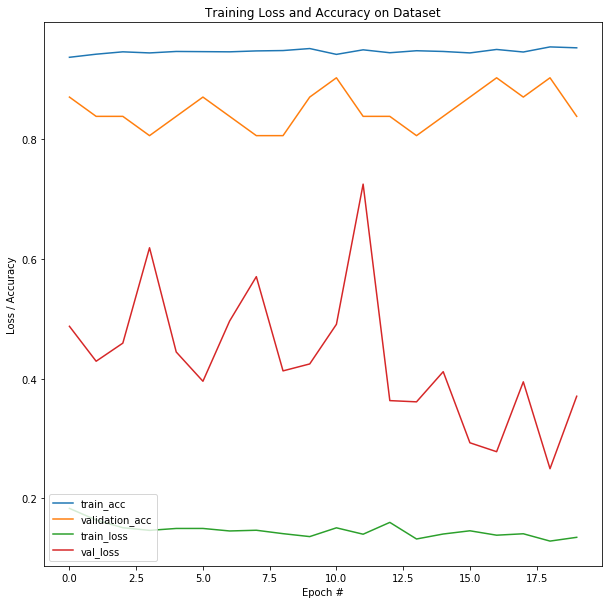

In [359]:
plt.figure(figsize = (10,10))
plt.plot(model_covid_split.history['accuracy'], label = "train_acc")
plt.plot(model_covid_split.history['val_accuracy'], label = "validation_acc")
plt.plot(model_covid_split.history['loss'], label = "train_loss")
plt.plot(model_covid_split.history['val_loss'], label = "val_loss")
plt.title('Training Loss and Accuracy on Dataset')
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='lower left')
plt.show()

In [360]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)', 'COVID (Class 2)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.86      0.97      0.91       390
   Normal (Class 1)       0.93      0.71      0.80       234
    COVID (Class 2)       0.76      0.97      0.85        32

          micro avg       0.88      0.88      0.88       656
          macro avg       0.85      0.88      0.86       656
       weighted avg       0.88      0.88      0.87       656
        samples avg       0.88      0.88      0.88       656



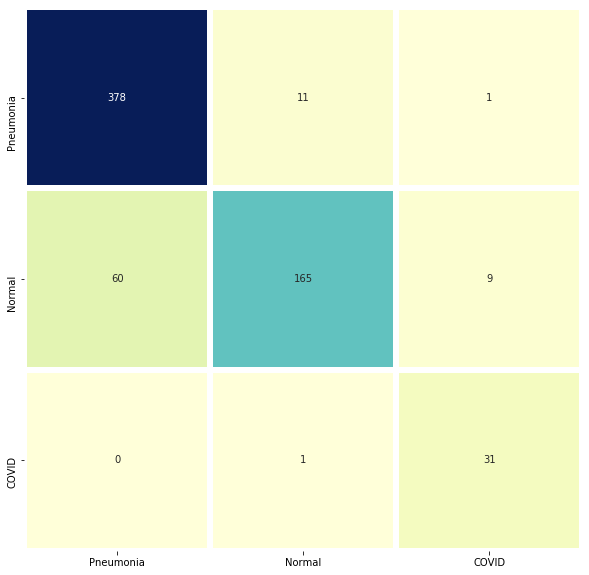

In [361]:
cm = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1))
cm_df = pd.DataFrame(cm)
plt.figure(figsize = (10,10))
sns.heatmap(cm_df, linewidth = 5 , annot = True, fmt='d',
           xticklabels = ['Pneumonia', 'Normal', 'COVID'],
           yticklabels = ['Pneumonia', 'Normal', 'COVID'],
           cbar = False, cmap = "YlGnBu")

In [362]:
model.save('model_PNEUCOVIDCOMPARE_attempt_split 25.05.2020.model')
model.save_weights('model_PNEUCOVIDCOMPARE_attempt_split 25.05.2020.h5')